In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from math import sqrt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error

In [2]:
import warnings
warnings.simplefilter(action='ignore',category=FutureWarning)

In [3]:
raw_cvs_data = pd.read_excel('karachi 100.xlsx')
df = raw_cvs_data.copy()

# Make sure the column name is correct
df['Date'] = pd.to_datetime(df['Date'], dayfirst=True)
df.set_index("Date", inplace=True)
df = df.asfreq('b')
data = df.fillna(method='ffill')


,Price
Date,
2022-01-03,44886.89
2022-01-04,45390.84
2022-01-05,45407.89
2022-01-06,45082.30
2022-01-07,45345.65


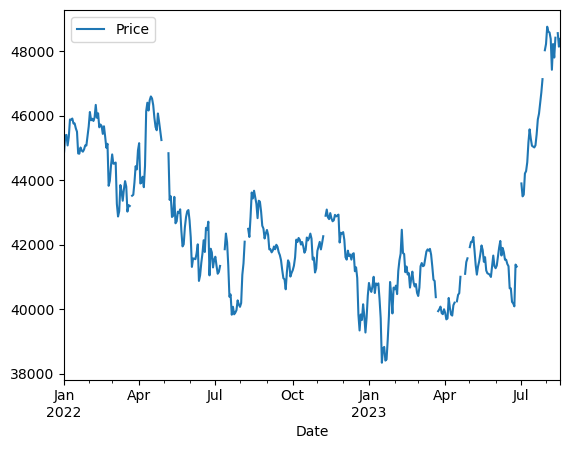

In [4]:
df.plot()
df.head()

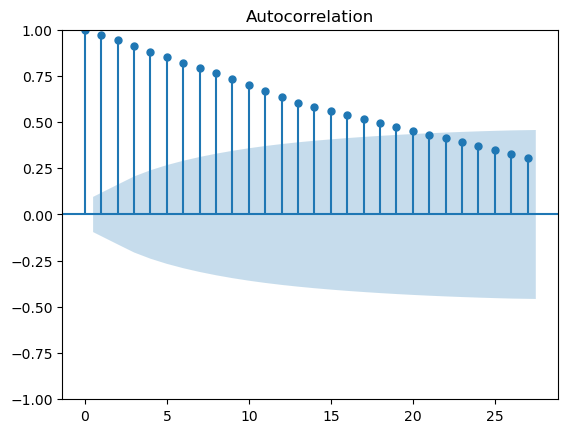

In [5]:
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(data)
plt.show()

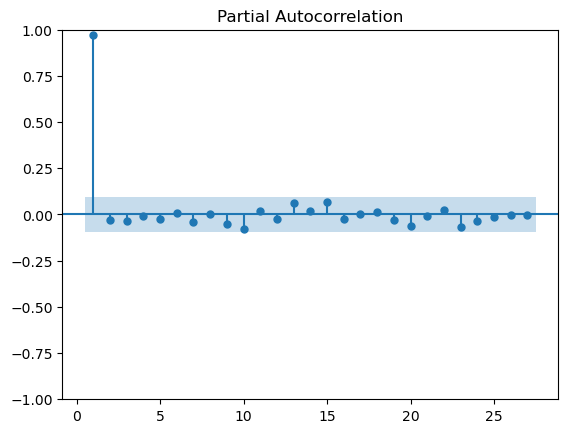

In [6]:
from statsmodels.graphics.tsaplots import plot_pacf
plot_pacf(data,zero=False)
plt.show()

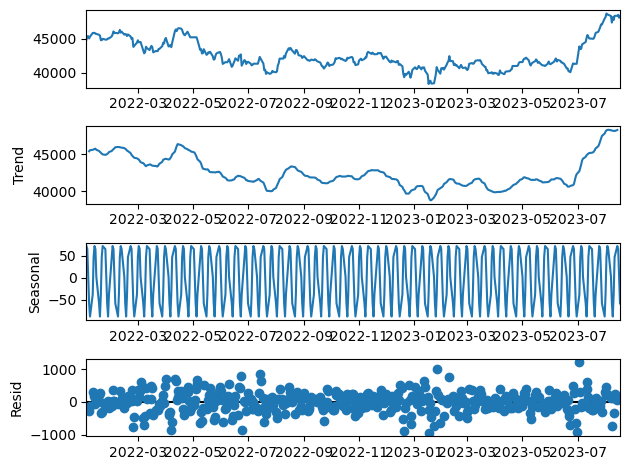

In [7]:
from statsmodels.tsa.seasonal import seasonal_decompose
from matplotlib import pyplot
series = data
result = seasonal_decompose(series, model='additive',period=7)
result.plot()
pyplot.show()

In [8]:
x = data.values
split = round(len(x)/2)
x1 = x[0:split]
x2 = x[split:]
print("Mean1 =%f" % x1.mean())
print("Mean2 =%f" % x2.mean())
print("Variance1 =%f" % x1.var())
print("Variance2 =%f" % x2.var())

Mean1 =43211.167028
Mean2 =41970.802217
Variance1 =3182989.186700
Variance2 =5162191.726225


In [9]:
import warnings
from statsmodels.tsa.stattools import adfuller

# Suppress the specific warning
warnings.filterwarnings("ignore", category=UserWarning, module="statsmodels.tsa.stattools")


In [10]:
from statsmodels.tsa.stattools import adfuller
results = adfuller(x)
results
print("ADF Statistics: %f" % results[0])
print("p-value: %f" % results[1])
print("Critical Values: ")
for key , values in results[4].items():
  print( "\t%s: %f" % (key , values))
if (results[1]>0.05):
  print("Series is not stationary")
else:
  print("Series is stationary")

ADF Statistics: -1.206464
p-value: 0.670809
Critical Values: 
	1%: -3.445904
	5%: -2.868397
	10%: -2.570423
Series is not stationary


In [11]:
from statsmodels.tsa.stattools import kpss
result = kpss(data)
print("p-values are: %f " % result[1])


p-values are: 0.010000 


In [12]:
 result = kpss(data)

In [13]:
size = int(len(data)*0.8)
df, df_test = data.iloc[:size], data.iloc[size:]

In [14]:
model=ARIMA(df,order=(1,1,1),seasonal_order=(5,1,3,7))

In [15]:
results = model.fit()

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [16]:
from sklearn.metrics import mean_squared_error
from math import sqrt
predictions = results.predict(start=len(df+1), end= len(df)+len(df_test)-1, dynamic=False)
#print(len(predictions))
#for i in range(len(predictions)):
#print('predicted=%f, expected=%f' % (predictions[i], df_test.ftse[i]))
rmse = sqrt(mean_squared_error(df_test, predictions))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 1931.798


In [17]:
test=df_test

In [18]:
test['prediction']=predictions

C:\Users\HK\AppData\Local\Temp\ipykernel_7044\3486747989.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['prediction']=predictions


In [19]:
test['difference']=test["Price"]-test['prediction']
print(test)

               Price    prediction   difference
Date                                           
2023-04-21  41007.82  41259.262211  -251.442211
2023-04-24  41007.82  41207.973409  -200.153409
2023-04-25  41007.82  41193.067239  -185.247239
2023-04-26  41099.58  41294.848083  -195.268083
2023-04-27  41463.91  41404.454120    59.455880
...              ...           ...          ...
2023-08-11  48424.40  45493.716619  2930.683381
2023-08-14  48424.40  45482.896012  2941.503988
2023-08-15  48565.75  45511.228675  3054.521325
2023-08-16  48146.43  45639.246212  2507.183788
2023-08-17  48386.12  45798.103159  2588.016841

[85 rows x 3 columns]


C:\Users\HK\AppData\Local\Temp\ipykernel_7044\2429729920.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['difference']=test["Price"]-test['prediction']


In [20]:
df = pd.DataFrame({'Actual': test.Price, 'Predicted': test.prediction})

<AxesSubplot:xlabel='Date'>

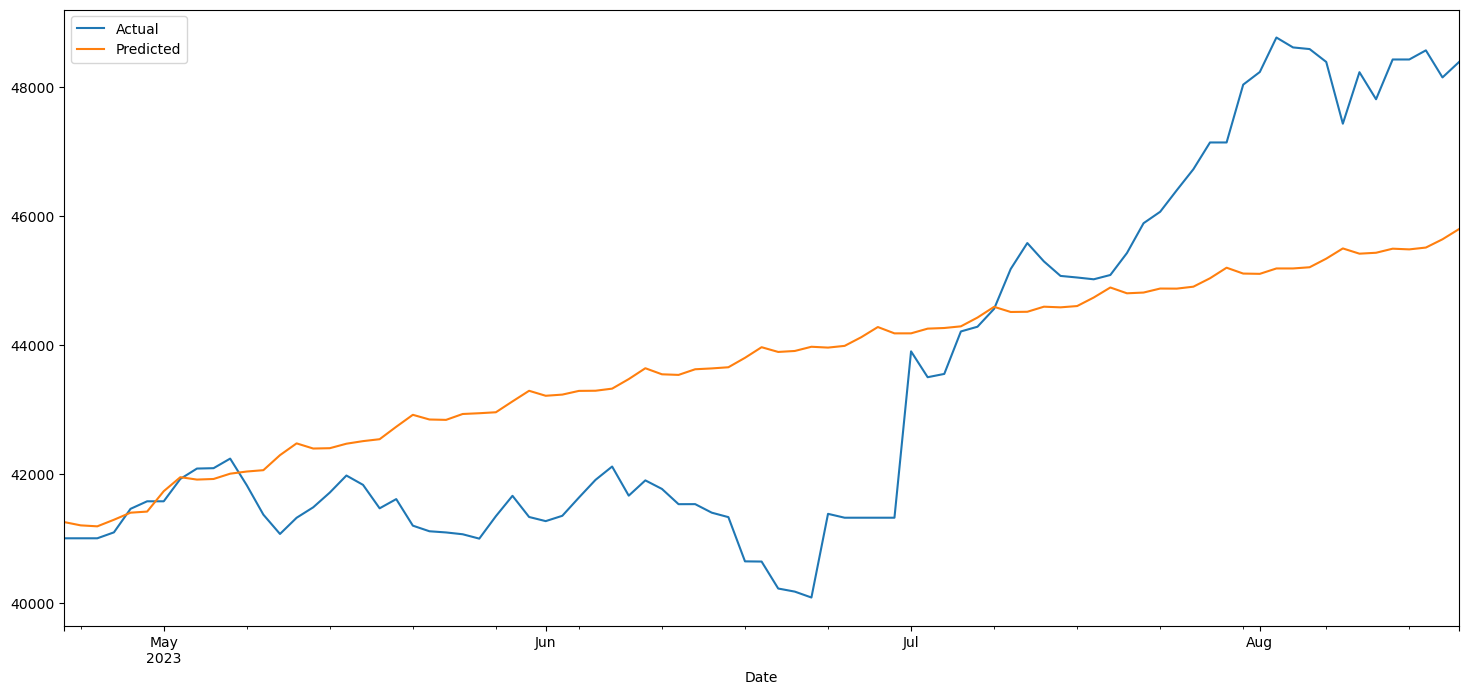

In [21]:
df.plot(kind='line',figsize=(18,8))

In [22]:
def train_test_split(data, n_train):
    return data[0:n_train], data[n_train:]

In [23]:
def evaluate_arima_model(data, arima_order, train_data_size_percent = 0.8):
  # prepare training dataset
    train_size = int(len(data) * train_data_size_percent)
    train, test = train_test_split(data, train_size)
    history = [x for x in train]
    # make predictions
    predictions = list()
    for t in range(len(test)):
        model = ARIMA(history, order=arima_order)
        model_fit = model.fit()
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        history.append(test[t])
    # calculate out of sample error
    error = mean_squared_error(test, predictions)
    return error, test, predictions

In [24]:
mse, test, predictions = evaluate_arima_model(data['Price'], arima_order=(5, 1, 8))

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximu

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximu

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximu

In [25]:
print("RMSE :",sqrt(mse))

RMSE : 447.6904201498747


In [28]:
final=pd.DataFrame({"Actual":test,"Forecast":predictions}, index=test.index)
# final = pd.DataFrame({"Actual": test, "Forecast": predictions, "Difference": test -predictions}, index=test.index)


In [29]:
final

,Actual,Forecast
Date,,
2023-04-21,41007.82,41058.573400
2023-04-24,41007.82,40997.624933
2023-04-25,41007.82,41020.100897
2023-04-26,41099.58,41023.386144
2023-04-27,41463.91,41149.094605
...,...,...
2023-08-11,48424.40,47751.121351
2023-08-14,48424.40,48344.379735
2023-08-15,48565.75,48339.349977


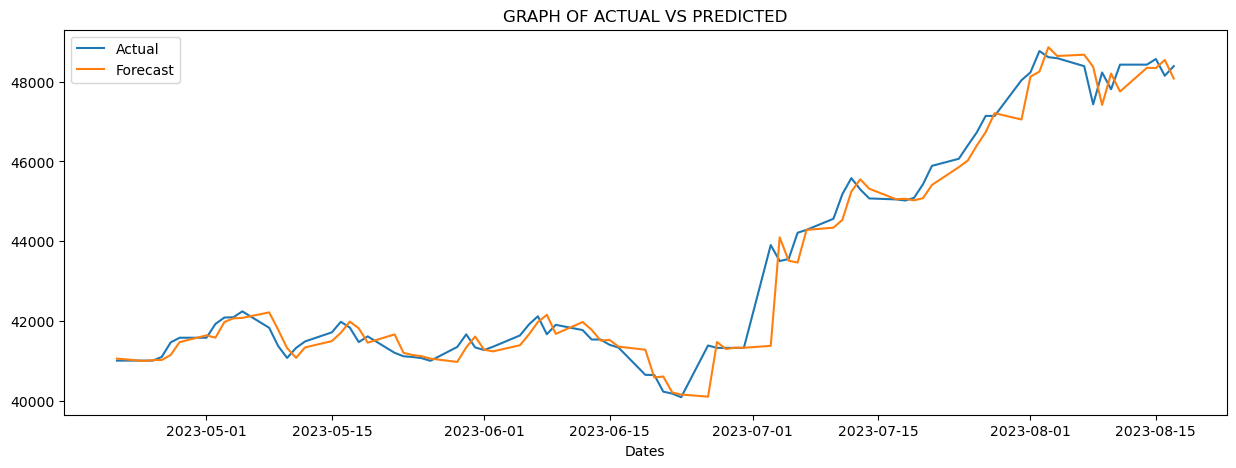

In [30]:
fig, ax = plt.subplots(figsize=(15,5))
plt.plot(final.Actual, label='Actual')
plt.plot(final.Forecast, label = "Forecast")
plt.xlabel('Dates')
plt.title('GRAPH OF ACTUAL VS PREDICTED')
plt.legend()
plt.show()

In [31]:
test = df_test.copy()  

test['Opening'] = predictions 

test['Difference'] = test["Price"] - test['Opening'] 
test.rename(columns={'Price': 'Closed'}, inplace=True)

print(test)


              Closed    prediction   difference       Opening  Difference
Date                                                                     
2023-04-21  41007.82  41259.262211  -251.442211  41058.573400  -50.753400
2023-04-24  41007.82  41207.973409  -200.153409  40997.624933   10.195067
2023-04-25  41007.82  41193.067239  -185.247239  41020.100897  -12.280897
2023-04-26  41099.58  41294.848083  -195.268083  41023.386144   76.193856
2023-04-27  41463.91  41404.454120    59.455880  41149.094605  314.815395
...              ...           ...          ...           ...         ...
2023-08-11  48424.40  45493.716619  2930.683381  47751.121351  673.278649
2023-08-14  48424.40  45482.896012  2941.503988  48344.379735   80.020265
2023-08-15  48565.75  45511.228675  3054.521325  48339.349977  226.400023
2023-08-16  48146.43  45639.246212  2507.183788  48541.804842 -395.374842
2023-08-17  48386.12  45798.103159  2588.016841  48076.672927  309.447073

[85 rows x 5 columns]


In [32]:
final

,Actual,Forecast
Date,,
2023-04-21,41007.82,41058.573400
2023-04-24,41007.82,40997.624933
2023-04-25,41007.82,41020.100897
2023-04-26,41099.58,41023.386144
2023-04-27,41463.91,41149.094605
...,...,...
2023-08-11,48424.40,47751.121351
2023-08-14,48424.40,48344.379735
2023-08-15,48565.75,48339.349977


In [33]:
lowest_value = final[['Actual', 'Forecast']].min().min()
highest_value = final[['Actual', 'Forecast']].max().max()

closing_value = final['Actual'].iloc[-1]

final['Opening'] = lowest_value
final['High'] = highest_value
final['Closing'] = closing_value

final['Difference'] = final['Actual'] - final['Forecast']

print(final)


              Actual      Forecast   Opening          High   Closing  \
Date                                                                   
2023-04-21  41007.82  41058.573400  40090.36  48860.967558  48386.12   
2023-04-24  41007.82  40997.624933  40090.36  48860.967558  48386.12   
2023-04-25  41007.82  41020.100897  40090.36  48860.967558  48386.12   
2023-04-26  41099.58  41023.386144  40090.36  48860.967558  48386.12   
2023-04-27  41463.91  41149.094605  40090.36  48860.967558  48386.12   
...              ...           ...       ...           ...       ...   
2023-08-11  48424.40  47751.121351  40090.36  48860.967558  48386.12   
2023-08-14  48424.40  48344.379735  40090.36  48860.967558  48386.12   
2023-08-15  48565.75  48339.349977  40090.36  48860.967558  48386.12   
2023-08-16  48146.43  48541.804842  40090.36  48860.967558  48386.12   
2023-08-17  48386.12  48076.672927  40090.36  48860.967558  48386.12   

            Difference  
Date                    
2023-04-21  -

In [34]:
final

,Actual,Forecast,Opening,High,Closing,Difference
Date,,,,,,
2023-04-21,41007.82,41058.573400,40090.36,48860.967558,48386.12,-50.753400
2023-04-24,41007.82,40997.624933,40090.36,48860.967558,48386.12,10.195067
2023-04-25,41007.82,41020.100897,40090.36,48860.967558,48386.12,-12.280897
2023-04-26,41099.58,41023.386144,40090.36,48860.967558,48386.12,76.193856
2023-04-27,41463.91,41149.094605,40090.36,48860.967558,48386.12,314.815395
...,...,...,...,...,...,...
2023-08-11,48424.40,47751.121351,40090.36,48860.967558,48386.12,673.278649
2023-08-14,48424.40,48344.379735,40090.36,48860.967558,48386.12,80.020265
2023-08-15,48565.75,48339.349977,40090.36,48860.967558,48386.12,226.400023
